link : 
- PRIVATE - ASK DSF 

# Method:

1. Clean data - severity medium, high or very high 
2. Claasify each disturbance typpe into on the 3 categories : 
    - 1 : Biotic-factor
    - 2 : Abiotic-factor
    - 3 : others 

In [7]:
#loading the data

import pandas as pd
df = pd.read_excel('/Users/arthurcalvi/Data/Disturbances_maps/Thierry Belouard & DSF/Veille_sanitaire/veille sanitaire DSF 2007_2023.xlsx', sheet_name='signalement0', header=2)

#convert to geopandas dataframe using lambert 93 coordinates
import geopandas as gpd
from shapely.geometry import Point

df['geometry'] = df.apply(lambda x: Point(x['Longitude'],x['Latitude']),axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs={'init': 'epsg:4326'})

columns = ["Année d'observation", "geometry", "Nom de commune saisie", "LIB_Département", 
           "LIB_Essence regroupée (ess. concernée)", "LIB_Feuillus/Résineux (ess. concernée)", 
            "Pourcentage de tiges atteintes", "Sévérité", 
             "LIB_Problème principal", "LIB_Type de problème", "Remarques"]

gdf = gdf[columns]


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Filtering on severity and causes

Keeping only severe and extremely severe events. 

The causes linked to mammals are not kept. 

In [13]:
gdf_filtered = gdf[gdf['Sévérité'] > 1]

In [15]:
gdf_filtered.shape

(59171, 11)

In [16]:
gdf_filtered['LIB_Type de problème'].unique()

array(['Autre symptôme', "Dégât d'origine entomologique",
       "Dégât d'origine pathologique", nan, 'Dégât dû à des végétaux',
       'Dégât du à des mammifères', "Dégât d'origine abiotique",
       'Inconnu ou indéterminé', "Dégât d'origine sylvicole",
       'Dégât du à des grands mammifères', 'Dégât du à une pollution',
       "Dégât dû à d'autres animaux"], dtype=object)

In [17]:
gdf_filtered = gdf_filtered[ gdf_filtered['LIB_Type de problème'].isin(["Dégât d'origine entomologique", \
                                 "Dégât d'origine abiotique", "Dégât dû à des végétaux", \
                                    "Dégât d'origine pathologique", "Dégât d'origine sylvicole", \
                                        "Dégât du à une pollution"]) ]

In [18]:
gdf_filtered.shape

(45561, 11)

In [19]:
gdf_filtered.columns

Index(['Année d'observation', 'geometry', 'Nom de commune saisie',
       'LIB_Département', 'LIB_Essence regroupée (ess. concernée)',
       'LIB_Feuillus/Résineux (ess. concernée)',
       'Pourcentage de tiges atteintes', 'Sévérité', 'LIB_Problème principal',
       'LIB_Type de problème', 'Remarques'],
      dtype='object')

In [20]:
sum(['sécheresse' in  x.lower() for x in gdf_filtered['LIB_Problème principal'].unique().tolist() ])

1

In [21]:
gdf_filtered['LIB_Problème principal'].unique().tolist()

['Pyrale du tronc',
 "Puceron vert de l'épicéa",
 'Charançon sauteur du  hêtre',
 'Maladie des bandes rouges (sur symptômes)',
 'Sclerophoma pithyophila',
 'Tordeuse verte du chêne',
 'Xylébore disparate',
 'Chermès du douglas',
 'Typographe',
 'Gui',
 'Coroebus du chêne',
 'Dégât entomologique indéterminé',
 'Hylésine du pin',
 'Carence en potassium',
 'Dendroctone',
 'Pissode du sapin',
 'Bris de neige',
 'Maladie des bandes rouges (échantillon de D. septospora)',
 'Dégât lié à la sécheresse',
 'Problème dû à un coup de chaleur',
 'Cul brun',
 'Dégât abiotique indéterminé',
 'Chancre du châtaignier',
 'Dégât dû à la foudre',
 'Dégât dû au vent',
 'Géométridé (espèce indéterminée)',
 'Dégât dû au gel',
 'Tortricidé (espèce indéterminée)',
 'Coléophore du mélèze',
 'Armillaire sur résineux',
 'Sphaeropsis des pins (Diplodia sapinea)',
 'Pityokteines spp',
 'Rouille vésiculeuse pins 2aiguilles',
 'Chancre du hêtre (N.ditissima)',
 'Fomes',
 'Lophyre roux',
 'Bombyx laineux',
 'Agrile du

## Classification

- Biotic-factors : "Dégât d'origine entomologique", "Dégât d'origine pathologique"
- Abiotic-factors : "Dégât d'origine abiotique", "Dégât d'origine sylvicole", "Dégât du à une pollution"
- Others : "Dégât dû à des végétaux"

In [22]:
def hl_class(x):
    if 'sécheresse' in x['LIB_Problème principal'].lower():
        return 'Drought-dieback'
    elif 'feu ' in x['LIB_Problème principal'].lower():
        return 'Fire'
    elif 'vent ' in x['LIB_Problème principal'].lower():
        return 'Storm'
    
    if x['LIB_Type de problème'] in ["Dégât d'origine entomologique", "Dégât d'origine pathologique", "Dégât dû à des végétaux"]:
        return 'Biotic'
    elif x['LIB_Type de problème'] in ["Dégât d'origine abiotique", "Dégât d'origine sylvicole", \
                                        "Dégât du à une pollution"]:
        return 'Other'
    else:
        return 'Other'

In [23]:
gdf_filtered['class'] = gdf_filtered.apply(hl_class, axis=1)

In [24]:
gdf_filtered.columns

Index(['Année d'observation', 'geometry', 'Nom de commune saisie',
       'LIB_Département', 'LIB_Essence regroupée (ess. concernée)',
       'LIB_Feuillus/Résineux (ess. concernée)',
       'Pourcentage de tiges atteintes', 'Sévérité', 'LIB_Problème principal',
       'LIB_Type de problème', 'Remarques', 'class'],
      dtype='object')

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


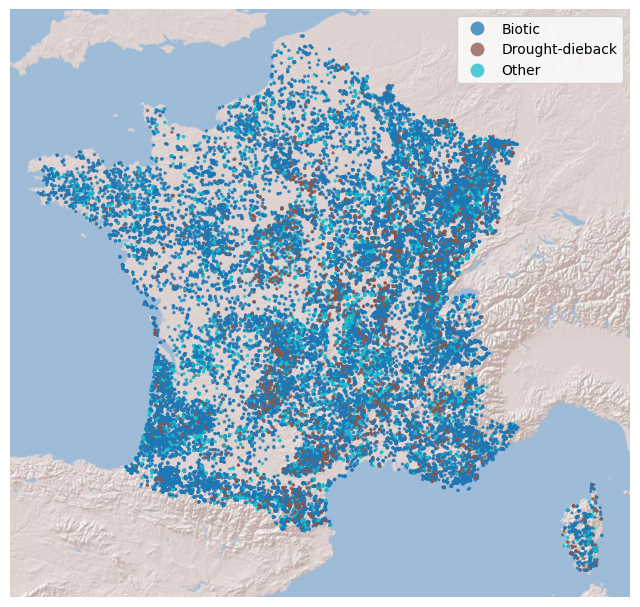

In [26]:
#custom cmap with [yellow, yellowbrown, light brown, red, dark bluegreen, grey]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

#color black in #

gplot = gdf_filtered.to_crs({'init': 'epsg:32631'})
import contextily as cx 
ax = gplot.plot(column='class', figsize=(8,8), legend=True, alpha=0.75, markersize=2)
ax.set_axis_off()
source = cx.providers.Esri.WorldShadedRelief
cx.add_basemap(ax, crs=gplot.crs, source=source, attribution=False)



In [17]:
ax.get_figure().savefig('../figures/classification_health-monitoring.png', dpi=200, bbox_inches='tight')

In [27]:
gdf_filtered["Année d'observation"].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023])

In [26]:
gdf_filtered.dtypes

Année d'observation                          int64
geometry                                  geometry
Nom de commune saisie                       object
LIB_Département                             object
LIB_Essence regroupée (ess. concernée)      object
LIB_Feuillus/Résineux (ess. concernée)      object
Pourcentage de tiges atteintes               int64
Sévérité                                     int64
LIB_Problème principal                      object
LIB_Type de problème                        object
Remarques                                   object
class                                       object
dtype: object

In [28]:
for col in ["Nom de commune saisie", "LIB_Département", "LIB_Essence regroupée (ess. concernée)",\
             "LIB_Feuillus/Résineux (ess. concernée)", "LIB_Problème principal", "LIB_Type de problème", \
                "Remarques", "class", "Sévérité"]:
    gdf_filtered[col] = gdf_filtered[col].astype(str)

gdf_filtered.rename(columns={"Année d'observation": "year"},  inplace=True)
gdf_filtered.to_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')

## Cleaning essence 

In [29]:
import geopandas as gpd

gdf = gpd.read_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')



In [30]:
gdf['LIB_Essence regroupée (ess. concernée)'].unique()

array(['Pins', 'Épicéas', 'Hêtre', 'Douglas', 'Chênes', 'Châtaignier',
       'Sapins', 'Bouleaux', 'Charme', 'Mélèzes', 'Autres feuillus',
       'Fruitiers', 'Peupliers', 'Autres résineux', 'Frênes', 'Cèdres',
       'Saules', 'Tremble', 'Noyers', 'Ormes', 'Érables', 'Aulnes',
       'Arbustes', 'nan', 'Taxodiacées', 'Tilleuls'], dtype=object)

In [32]:
import numpy as np

# Dictionary to hold translations
translation_dict = {
    'Épicéas': 'Spruces',
    'Chênes': 'Oaks',
    'Sapins': 'Firs',
    'Bouleaux': 'Birches',
    'Pins': 'Pines',
    'Douglas': 'Douglas',
    'Charme': 'Hornbeam',
    'Autres feuillus': 'Other Broadleaves',
    'Fruitiers': 'Fruit Trees',
    'Peupliers': 'Poplars',
    'Hêtre': 'Beech',
    'Mélèzes': 'Larches',
    'Frênes': 'Ash Trees',
    'Cèdres': 'Cedars',
    'Tremble': 'Aspen',
    'Saules': 'Willows',
    'Ormes': 'Elms',
    'Châtaignier': 'Chestnut',
    'Érables': 'Maples',
    'Arbustes': 'Shrubs',
    'Aulnes': 'Alders',
    'Noyers': 'Walnuts',
    'Autres résineux': 'Other Conifers',
    'nan': np.nan,  # Assuming 'nan' is kept as is
    'Taxodiacées': 'Taxodiaceae (a family of coniferous trees)',
    'Tilleuls': 'Lindens'
}


gdf['essence'] = gdf['LIB_Essence regroupée (ess. concernée)'].apply(lambda x: translation_dict[x])

In [33]:
gdf['LIB_Feuillus/Résineux (ess. concernée)'].unique()

def get_tree_type(x):
    if x == 'Conifère':
        return 'conifer'
    elif x == 'Feuillu':
        return 'broadleaf'
    else:
        return np.nan 
    
gdf['tree_type'] = gdf['LIB_Feuillus/Résineux (ess. concernée)'].apply(get_tree_type)

In [34]:
gdf[['year', 'geometry', 'LIB_Problème principal', 'Remarques', 'Sévérité', 'class', 'essence', 'tree_type']].to_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')

# Simplified version

In [35]:
import geopandas as gpd
epsg = 'epsg:2154'
hm = gpd.read_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet').to_crs(epsg)

In [36]:
#hm
# def get_class(x):
#     if x  == 'biotic-factor':
#         return 'Biotic'
#     else :
#         return 'Other'
    
# hm['class'] = hm['class'].apply(get_class)
hm['year'] = hm['year'].astype(int)
hm.drop_duplicates(inplace=True)
hm.dropna(inplace=True)

hm.rename(columns={'LIB_Problème principal':'cause', 'Remarques':'notes'}, inplace=True)

In [37]:
hm

,year,geometry,cause,notes,Sévérité,class,essence,tree_type
6,2007,POINT (217861.413 6784765.670),Pyrale du tronc,"Attaques fortes de plusieurs années, beaucoup ...",2,Biotic,Pines,conifer
10,2007,POINT (233924.714 6796466.646),Puceron vert de l'épicéa,Attaque de pucerons sévère sur l'ensemble du s...,3,Biotic,Spruces,conifer
12,2007,POINT (238520.885 6771770.177),Charançon sauteur du hêtre,Certains arbres ont les feuilles entièrement c...,2,Biotic,Beech,broadleaf
13,2007,POINT (250493.827 6742807.991),Maladie des bandes rouges (sur symptômes),nan,2,Biotic,Pines,conifer
15,2007,POINT (619429.668 6419467.414),Sclerophoma pithyophila,nan,2,Biotic,Douglas,conifer
...,...,...,...,...,...,...,...,...
73297,2023,POINT (662264.172 6253619.062),Dégât lié à la sécheresse,nan,3,Drought-dieback,Other Broadleaves,broadleaf
73298,2023,POINT (670287.917 6231398.863),Dégât lié à la sécheresse,nan,3,Drought-dieback,Other Broadleaves,broadleaf
73299,2023,POINT (478407.092 6345010.687),Sténographe,Futaie régulière de pin maritime 35-39 ans pré...,4,Biotic,Pines,conifer
73302,2023,POINT (984620.346 6324850.078),Mineuse des aiguilles du sapin,La mineuse c'est étendu a tous les sapins de c...,3,Biotic,Firs,conifer


In [38]:
hm.to_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet')

# Using severity to disambiguate biotic-dieback and biotic-mortality 

In [39]:
import geopandas as gpd

hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet')

In [40]:
hm

,year,geometry,cause,notes,Sévérité,class,essence,tree_type
6,2007,POINT (217861.413 6784765.670),Pyrale du tronc,"Attaques fortes de plusieurs années, beaucoup ...",2,Biotic,Pines,conifer
10,2007,POINT (233924.714 6796466.646),Puceron vert de l'épicéa,Attaque de pucerons sévère sur l'ensemble du s...,3,Biotic,Spruces,conifer
12,2007,POINT (238520.885 6771770.177),Charançon sauteur du hêtre,Certains arbres ont les feuilles entièrement c...,2,Biotic,Beech,broadleaf
13,2007,POINT (250493.827 6742807.991),Maladie des bandes rouges (sur symptômes),nan,2,Biotic,Pines,conifer
15,2007,POINT (619429.668 6419467.414),Sclerophoma pithyophila,nan,2,Biotic,Douglas,conifer
...,...,...,...,...,...,...,...,...
73297,2023,POINT (662264.172 6253619.062),Dégât lié à la sécheresse,nan,3,Drought-dieback,Other Broadleaves,broadleaf
73298,2023,POINT (670287.917 6231398.863),Dégât lié à la sécheresse,nan,3,Drought-dieback,Other Broadleaves,broadleaf
73299,2023,POINT (478407.092 6345010.687),Sténographe,Futaie régulière de pin maritime 35-39 ans pré...,4,Biotic,Pines,conifer
73302,2023,POINT (984620.346 6324850.078),Mineuse des aiguilles du sapin,La mineuse c'est étendu a tous les sapins de c...,3,Biotic,Firs,conifer


In [45]:
def desambiguate(row):
    if row['class'] == 'Biotic':
        if int(row['Sévérité']) < 4:
            return 'Biotic-dieback'
        else:
            return 'Biotic-mortality'
        
    else :
        return row['class']
    
hm['class'] = hm.apply(desambiguate, axis=1)

In [46]:
hm['class'].value_counts()

class
Biotic-dieback      15840
Biotic-mortality     9563
Other                5852
Drought-dieback      3018
Name: count, dtype: int64

In [ ]:
hm.rename(columns={'Sévérité':'severity'}, inplace=True)
hm.to_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet')